## Using BERT to Classify text 



In [1]:
import os
import random
import datetime
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator


USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if USE_CUDA:
    torch.cuda.manual_seed(seed)

COLAB = True

if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/Shareddrives/Adv ML Project/Data/"
else:
    # Change path to appropriate location
    PATH = "/Users/kilaf/OneDrive - The University of Chicago/CAPP255/Project"
    

Using cuda.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Step 1: Load in pre-processed data and split into train, validation and test datasets using seed 30255

In [2]:
df = pd.read_csv(os.path.join(PATH + "preprocessed_data.csv"))

In [3]:
len(df)

6115

Converting the classes we want to classify to integers

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df['CLASS'])

decoded_labels = le.inverse_transform(labels)
print(set(labels), set(decoded_labels))

{0, 1, 2, 3, 4} {'Fission and Nuclear Technologies', 'Renewable Energy Sources', 'Energy Storage, Conversion, and Utilization', 'Fossil Fuels', 'Environmental Sciences'}


In [5]:
df['LABEL'] = le.fit_transform(df['CLASS'])
tmp_dict = df[['CLASS', 'LABEL']].drop_duplicates().set_index('LABEL').to_dict('index')
CATEGORY_DICT = {label: sub_dict['CLASS'] for label, sub_dict in tmp_dict.items()}

print(CATEGORY_DICT)

{0: 'Energy Storage, Conversion, and Utilization', 1: 'Environmental Sciences', 2: 'Fission and Nuclear Technologies', 3: 'Fossil Fuels', 4: 'Renewable Energy Sources'}


Using the BERT_TOKENIZED column to create our dataloader with the intergerized labels

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from transformers import BertTokenizer

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [8]:
def tokenize_text(text):
    """
    Truncating the text to 512 for consistency's sake
    """
    return tokenizer.encode_plus(text,
                                  add_special_tokens=True,
                                  max_length=320,
                                  padding='max_length',
                                  return_attention_mask=True,
                                  return_tensors='pt',
                                  truncation=True)

tokenized_text = df['DESCRIPTION'].apply(tokenize_text)

In [9]:
#

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# create DataLoader - need to stack the lists of tensors into one tensor
input_ids = torch.stack([row['input_ids'] for row in tokenized_text])
attention_mask = torch.stack([row['attention_mask'] for row in tokenized_text])

# Concatenating the Embeddings, Attention Mask and Labels
dataset = TensorDataset(input_ids, attention_mask, torch.tensor(labels, dtype=torch.long))

In [11]:
# compute train/validation/test split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# split dataset randomly into train/validation/test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# create data loaders for each set
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [12]:
import torch.nn as nn
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
device = torch.device('cuda')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Step 2: Model Training

In [13]:
def train_model(model, train_data_loader, optimizer):
    model.train()

    for batch in train_data_loader:
        input_ids, attention_mask, labels = batch
        if USE_CUDA:
                input_ids, attention_mask, labels = input_ids.squeeze(1).cuda(), attention_mask.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels)

        loss.backward()
        optimizer.step()

In [14]:
from sklearn.metrics import confusion_matrix, classification_report


In [21]:
def validate(model, data_loader, num_classes):
    model.eval() # set model to evaluation mode
    
    # initialize performance metrics
    num_correct = 0
    num_samples = 0
    losses = []
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    
    # create empty lists for storing predicted labels and true labels
    all_preds = []
    all_labels = []
    
    # iterate over batches in validation set
    for batch in data_loader:
        # extract inputs and targets from batch
        input_ids, attention_mask, labels = batch
        if USE_CUDA:
            input_ids, attention_mask, labels = input_ids.squeeze(1).cuda(), attention_mask.cuda(), labels.cuda()

        # compute model outputs and loss
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
        
        # update performance metrics
        losses.append(loss.item())
        _, preds = torch.max(outputs.logits, dim=1)
        num_correct += (preds == labels).sum().item()
        num_samples += labels.size(0)
        
        for i in range(num_classes):
            true_positives[i] += ((preds == i) & (labels == i)).sum().item()
            false_positives[i] += ((preds == i) & (labels != i)).sum().item()
            false_negatives[i] += ((preds != i) & (labels == i)).sum().item()
        
        # append predicted labels and true labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # compute average loss and accuracy
    avg_loss = sum(losses) / len(losses)
    accuracy = num_correct / num_samples
    
    # compute precision, recall, and F1 score for each class
    precision = []
    recall = []
    f1_score = []
    confusion_matrices = []
    for i in range(num_classes):
        precision.append(true_positives[i] / (true_positives[i] + false_positives[i] + 1e-10))
        recall.append(true_positives[i] / (true_positives[i] + false_negatives[i] + 1e-10))
        f1_score.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10))

                    # create confusion matrix for the current class
    
    print(f'Validation Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1_score}')

    # create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)


     # Add labels for the classification report
    predicted_labels = [CATEGORY_DICT[pred] for pred in all_preds]
    true_labels = [CATEGORY_DICT[true] for true in all_labels]
    report = classification_report(predicted_labels, true_labels)
    print(report)

    return avg_loss, accuracy, precision, recall, f1_score, cm

In [16]:
num_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
val_loss = []
val_acc = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # train model on training set
    train_model(model, train_loader, optimizer)
    
    # validate model on validation set
    avg_loss, accuracy, precision, recall, f1_score, cm = validate(model, val_loader, 5)
    val_loss.append(avg_loss)
    val_acc.append(accuracy)

Epoch 1/5
Validation Loss: 4.5989 | Accuracy: 0.2879
Precision: [0.9199999999963201, 0.9285714285647959, 0.23313609467452862, 0.9393939393910927, 0.0]
Recall: [0.12169312169305731, 0.07262569832398177, 0.9999999999994924, 0.1565656565655775, 0.0]
F1 Score: [0.2149532710072015, 0.13471502589314077, 0.37811900188865, 0.26839826837354624, 0.0]
Confusion Matrix:
[[ 23   0 166   0   0]
 [  0  13 166   0   0]
 [  0   0 197   0   0]
 [  0   1 166  31   0]
 [  2   0 150   2   0]]
              precision    recall  f1-score   support

           0       0.92      0.12      0.21       189
           1       0.93      0.07      0.13       179
           2       0.23      1.00      0.38       197
           3       0.94      0.16      0.27       198
           4       0.00      0.00      0.00       154

    accuracy                           0.29       917
   macro avg       0.60      0.27      0.20       917
weighted avg       0.62      0.29      0.21       917

Epoch 2/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.1750 | Accuracy: 0.6260
Precision: [0.7823529411760104, 0.7872340425526332, 0.43693693693683855, 0.839506172838988, 0.0]
Recall: [0.7037037037033315, 0.620111731843229, 0.984771573603561, 0.68686868686834, 0.0]
F1 Score: [0.7409470751586409, 0.6937499999502714, 0.6053042121257222, 0.7555555555056358, 0.0]
Confusion Matrix:
[[133   5  45   6   0]
 [  4 111  55   9   0]
 [  1   2 194   0   0]
 [  4   4  54 136   0]
 [ 28  19  96  11   0]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       189
           1       0.79      0.62      0.69       179
           2       0.44      0.98      0.61       197
           3       0.84      0.69      0.76       198
           4       0.00      0.00      0.00       154

    accuracy                           0.63       917
   macro avg       0.57      0.60      0.56       917
weighted avg       0.59      0.63      0.58       917

Epoch 3/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.2066 | Accuracy: 0.7710
Precision: [0.7511737089198351, 0.7558139534879327, 0.8284313725486135, 0.7422222222218924, 0.7864077669895277]
Recall: [0.8465608465603986, 0.7262569832398178, 0.8578680203041331, 0.8434343434339175, 0.5259740259736845]
F1 Score: [0.7960199004472945, 0.7407407406903387, 0.8428927680293954, 0.7895981086968753, 0.6303501945040076]
Confusion Matrix:
[[160   8   5  10   6]
 [  7 130  22  16   4]
 [ 11  10 169   4   3]
 [ 13   7   2 167   9]
 [ 22  17   6  28  81]]
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       189
           1       0.76      0.73      0.74       179
           2       0.83      0.86      0.84       197
           3       0.74      0.84      0.79       198
           4       0.79      0.53      0.63       154

    accuracy                           0.77       917
   macro avg       0.77      0.76      0.76       917
weighted avg       0.77      0.77      0.77       917

Ep

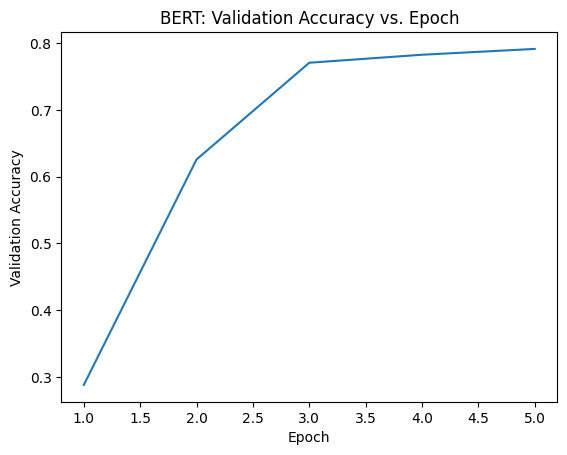

In [17]:
import matplotlib.pyplot as plt

# plot validation loss
plt.plot(range(1, num_epochs+1), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('BERT: Validation Accuracy vs. Epoch')
plt.show()

In [23]:
avg_loss, accuracy, precision, recall, f1_score, cm = validate(model, test_loader, 5)

Validation Loss: 0.6777 | Accuracy: 0.8148
Precision: [0.8857142857136532, 0.8961038961033143, 0.8465116279065831, 0.7688442211051413, 0.7190476190472767]
Recall: [0.7848101265817818, 0.7301587301583439, 0.8965517241374894, 0.8499999999995278, 0.8031914893612749]
F1 Score: [0.8322147650502951, 0.8046647229821214, 0.8708133970788112, 0.8073878627465334, 0.7587939697990178]
Confusion Matrix:
[[124   3   4   8  19]
 [  3 138  15  15  18]
 [  3   5 182   2  11]
 [  4   6   6 153  11]
 [  6   2   8  21 151]]
                                             precision    recall  f1-score   support

Energy Storage, Conversion, and Utilization       0.78      0.89      0.83       140
                     Environmental Sciences       0.73      0.90      0.80       154
           Fission and Nuclear Technologies       0.90      0.85      0.87       215
                               Fossil Fuels       0.85      0.77      0.81       199
                   Renewable Energy Sources       0.80      0.72 

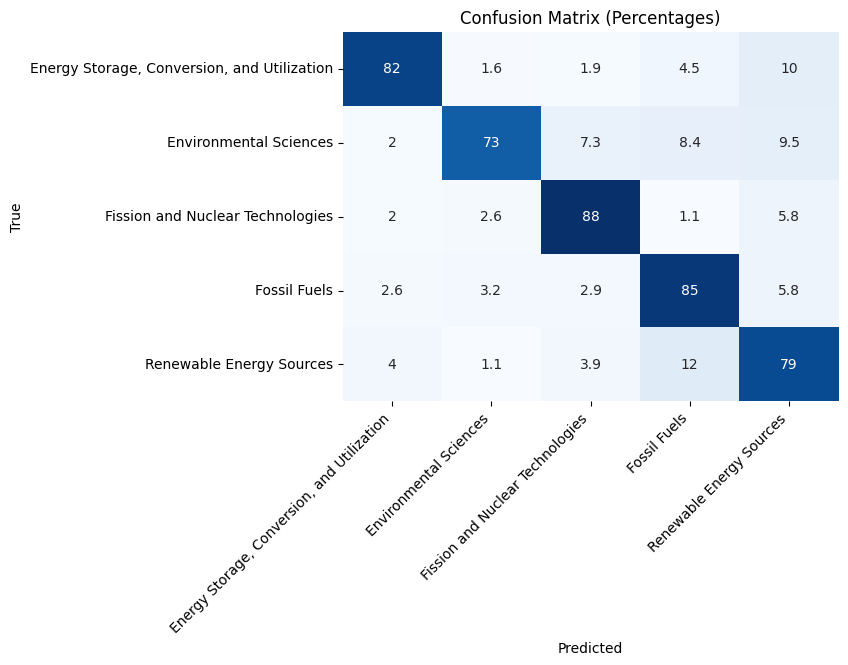

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate percentages
cm = (cm / cm.sum(axis=1)) * 100

# Define the class labels
class_labels = ['Energy Storage, Conversion, and Utilization', 'Environmental Sciences',
                'Fission and Nuclear Technologies', 'Fossil Fuels', 'Renewable Energy Sources']

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels, title, and axis ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Percentages)')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)


# Display the plot
plt.show()